In [1]:
%reload_ext autoreload
%autoreload 2

# 2.02: Evaluating Bagged Quantile Regression MIA

We compute the true positive rate and false positive rate of the quantile regression MIA on heldout data. First we load the model and evaluation data.

In [2]:
from quantile_diffusion_mia.config import DATASET_CONFIG, MODEL_CONFIG
import numpy as np

dataset_name = "CIFAR10"
num_attackers = 7

alpha_min, alpha_max = 1e-8, 1e-1
num_alpha = 300
alphas = np.logspace(np.log10(alpha_min), np.log10(alpha_max), num_alpha)
alpha_of_interest = 1e-2

config = DATASET_CONFIG[dataset_name]
model_config = MODEL_CONFIG["CIFAR10_QUANTILE"]

from quantile_diffusion_mia.modeling.train import load_quantile_model
import numpy as np
from quantile_diffusion_mia.dataset import QuantileRegressionDataset
from tqdm import tqdm

# Load the model
models = []
for attacker in tqdm(range(num_attackers)):
    model_dir = "../" + config["quantile_regression_model_path"]
    model = load_quantile_model(model_dir, channel_reduce=model_config["resnet_channel_reduce"], alphas=alphas, attacker=attacker).to("cuda")
    model.eval()
    models.append(model)

# Load the eval indices
split_path = "../" + config['quantile_regression_split_path']
output = np.load(split_path)
quantile_eval_indices = output['quantile_eval_indices']

# Load the dataset
data_path = "../" + config['quantile_regression_data_path']
eval_dataset = QuantileRegressionDataset.load(data_path)
eval_dataset.set_indices(quantile_eval_indices)

2024-11-21 20:58:49.995 | INFO     | quantile_diffusion_mia.config:<module>:11 - PROJ_ROOT path is: /work3/nkale/ml-projects/quantile-diffusion-mia
100%|██████████| 7/7 [00:04<00:00,  1.58it/s]


In [3]:
import torch

# Count the number of parameters in model[0]
num_params = sum(p.numel() for p in models[0].parameters())
print(f'The number of parameters in model[0]: {num_params}')

The number of parameters in model[0]: 54300


In [4]:
from torch.utils.data import DataLoader
import pandas as pd
import torch

config = MODEL_CONFIG[f'{dataset_name}_QUANTILE']
results = []

eval_loader = DataLoader(eval_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=4)

alpha_idx = (np.abs(alphas - alpha_of_interest)).argmin()
print(f'Alpha index of interest: {alphas[alpha_idx]}')

with torch.no_grad():
    for data in eval_loader:
        original_images, reconstructed_images, targets, labels = data
        features = torch.cat((original_images, reconstructed_images), dim=1).to("cuda")
        
        # Collect predictions from each model and store them in a dictionary
        model_predictions = {}
        for idx, model in enumerate(models):
            model.eval()
            predictions = model(features).squeeze().cpu().numpy()
            model_predictions[f'Predicted_Model_{idx+1}'] = predictions[:, alpha_idx]  # Name columns by model index

        # Convert targets to the same scale if necessary
        targets = targets.cpu().numpy()

        # Append each result to a dictionary with model-specific predictions, target, and label
        for i in range(len(targets)):
            result = {model_col: model_predictions[model_col][i] for model_col in model_predictions}
            result.update({'Actual': targets[i], 'Label': labels[i]})
            results.append(result)

# Create DataFrame with predictions from each model as separate columns
results_df = pd.DataFrame(results)
results_df.head()

Alpha index of interest: 0.009847160957933764


,Predicted_Model_1,Predicted_Model_2,Predicted_Model_3,Predicted_Model_4,Predicted_Model_5,Predicted_Model_6,Predicted_Model_7,Actual,Label
0,6.695024,6.755731,6.651577,6.712900,6.591811,6.643818,6.781760,6.897361,member
1,6.912315,6.924695,6.978778,6.870438,6.958836,6.908032,6.827751,7.054512,member
2,6.985460,6.839432,6.905888,6.862724,6.854664,6.911033,6.915843,7.039750,member
3,6.706974,6.689602,6.831204,6.818318,6.626443,6.687568,6.759250,6.788832,member
4,6.744992,6.652035,6.797266,6.705458,6.763465,6.704925,6.766403,6.675266,member


We can first plot the real t-errors alongside the median alpha-quantile from our bag.

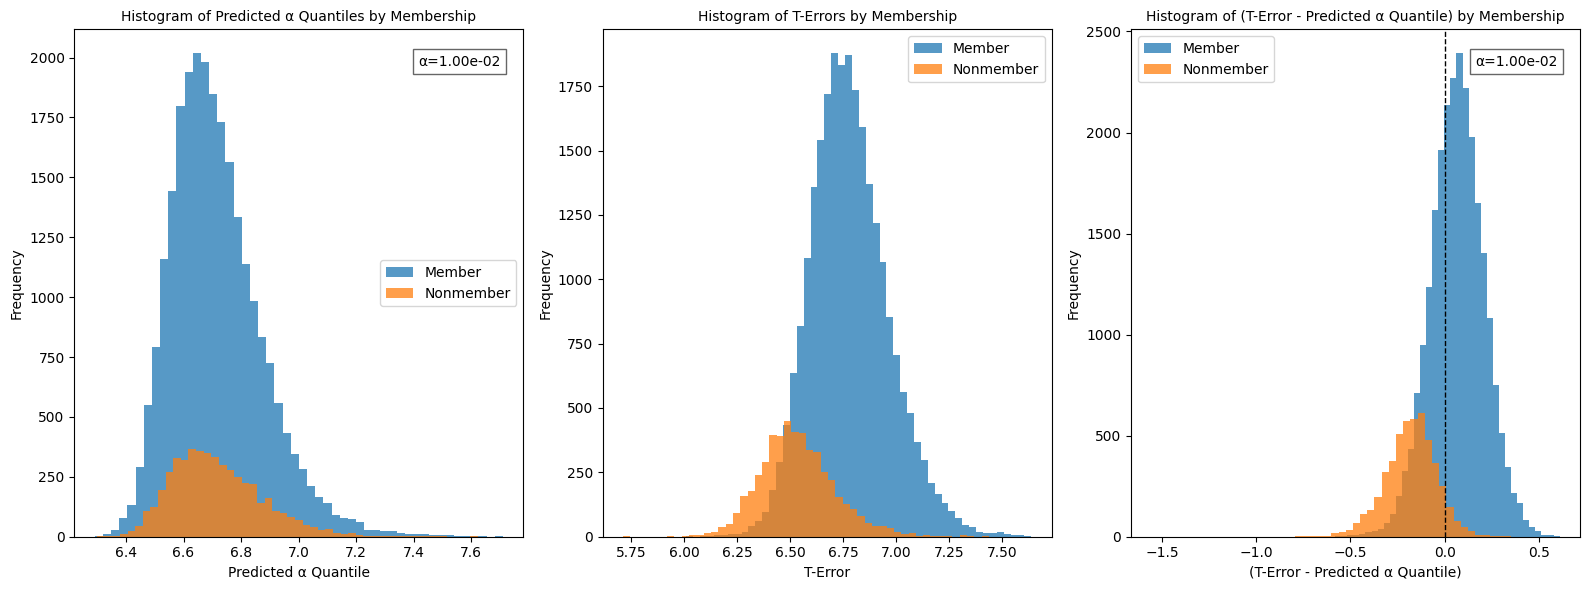

In [5]:
import matplotlib.pyplot as plt

# Convert labels to numpy array for easier indexing
labels = np.array(results_df['Label'])

# Filter predicted values by labels
member_predicted = results_df['Predicted_Model_1'][labels == 'member']
nonmember_predicted = results_df['Predicted_Model_1'][labels == 'nonmember']

# Filter t_errors by labels
member_t_errors = results_df['Actual'][labels == 'member']
nonmember_t_errors = results_df['Actual'][labels == 'nonmember']

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(16, 6))

# Create annotation of alphas
alpha_annotation = f"{alpha_of_interest:.2e}"

# Plot histograms of predicted values
axs[0].hist(member_predicted, bins=50, alpha=0.75, label='Member')
axs[0].hist(nonmember_predicted, bins=50, alpha=0.75, label='Nonmember')
axs[0].set_title('Histogram of Predicted α Quantiles by Membership', fontsize=10)
axs[0].set_xlabel('Predicted α Quantile')
axs[0].set_ylabel('Frequency')
axs[0].legend()
axs[0].annotate(f'α={alpha_annotation}', xy=(0.95, 0.95), xycoords='axes fraction', fontsize=10,
                horizontalalignment='right', verticalalignment='top', bbox=dict(facecolor='white', alpha=0.6))

# Plot histograms of t-errors
axs[1].hist(member_t_errors, bins=50, alpha=0.75, label='Member')
axs[1].hist(nonmember_t_errors, bins=50, alpha=0.75, label='Nonmember')
axs[1].set_title('Histogram of T-Errors by Membership', fontsize=10)
axs[1].set_xlabel('T-Error')
axs[1].set_ylabel('Frequency')
axs[1].legend()

# Plot histogram of t-error - predicted quantile
member_diff = member_t_errors - member_predicted
nonmember_diff = nonmember_t_errors - nonmember_predicted
axs[2].hist(member_diff, bins=50, alpha=0.75, label='Member')
axs[2].hist(nonmember_diff, bins=50, alpha=0.75, label='Nonmember')
axs[2].axvline(0, color='k', linestyle='dashed', linewidth=1)
axs[2].set_title('Histogram of (T-Error - Predicted α Quantile) by Membership', fontsize=10)
axs[2].set_xlabel('(T-Error - Predicted α Quantile)')
axs[2].set_ylabel('Frequency')
axs[2].legend()
axs[2].annotate(f'α={alpha_annotation}', xy=(0.95, 0.95), xycoords='axes fraction', fontsize=10,
                horizontalalignment='right', verticalalignment='top', bbox=dict(facecolor='white', alpha=0.6))

plt.tight_layout()
plt.show()

Next, we can compute the number of correct predictions.

In [6]:
# Calculate whether each model's prediction is greater than the actual value
comparison_df = results_df.loc[:, 'Predicted_Model_1':f'Predicted_Model_{num_attackers}'].lt(results_df['Actual'], axis=0)
# Sum across each row to count the number of models predicting > actual, then determine if majority
results_df['Majority_Vote'] = comparison_df.sum(axis=1) > (len(comparison_df.columns) / 2)
# If the model predictions is less than the actual t-error, the t-error falls within the confidence interval.
# So if most model predictions are less than the actual t-error, the majority vote is nonmember.
results_df['Majority_Vote'] = results_df['Majority_Vote'].replace({True: 'Member', False: 'Nonmember'})

# Display the updated DataFrame
results_df.head()

,Predicted_Model_1,Predicted_Model_2,Predicted_Model_3,Predicted_Model_4,Predicted_Model_5,Predicted_Model_6,Predicted_Model_7,Actual,Label,Majority_Vote
0,6.695024,6.755731,6.651577,6.712900,6.591811,6.643818,6.781760,6.897361,member,Member
1,6.912315,6.924695,6.978778,6.870438,6.958836,6.908032,6.827751,7.054512,member,Member
2,6.985460,6.839432,6.905888,6.862724,6.854664,6.911033,6.915843,7.039750,member,Member
3,6.706974,6.689602,6.831204,6.818318,6.626443,6.687568,6.759250,6.788832,member,Member
4,6.744992,6.652035,6.797266,6.705458,6.763465,6.704925,6.766403,6.675266,member,Nonmember


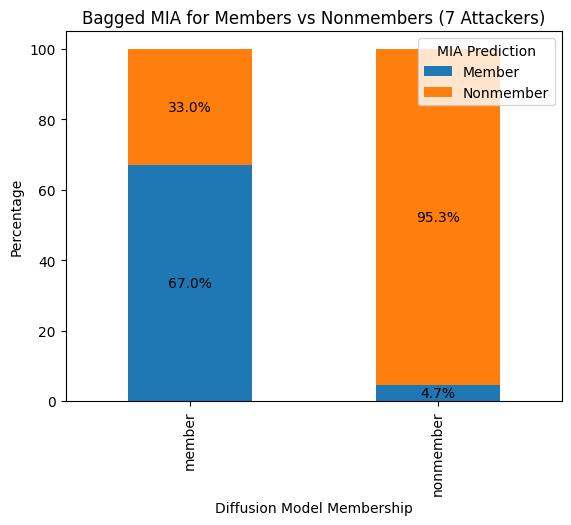

In [7]:
import matplotlib.pyplot as plt

# Calculate vote counts
vote_counts = results_df.groupby(['Label', 'Majority_Vote']).size().unstack(fill_value=0)

# Normalize the vote counts to percentages
vote_counts_percentage = vote_counts.div(vote_counts.sum(axis=1), axis=0) * 100

# Plot the data
ax = vote_counts_percentage.plot(kind='bar', stacked=True)
plt.title(f'Bagged MIA for Members vs Nonmembers ({num_attackers} Attackers)')
plt.xlabel('Diffusion Model Membership')
plt.ylabel('Percentage')
plt.legend(title='MIA Prediction')

# Add numerical labels
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height:.1f}%', (x + width / 2, y + height / 2), ha='center', va='center')

plt.show()